In [1]:
import numpy as np
import scipy
import enum
import matplotlib.pyplot as plt
from time import time
from xclib.data import data_utils

### Loading the data

In [2]:
# Train data
x_train = data_utils.read_sparse_file('./ass3_parta_data/train_x.txt').toarray()
y_train = np.loadtxt('./ass3_parta_data/train_y.txt', dtype=int)

# Test data
x_test = data_utils.read_sparse_file('./ass3_parta_data/test_x.txt').toarray()
y_test = np.loadtxt('./ass3_parta_data/test_y.txt', dtype=int)

# Validation data
x_val = data_utils.read_sparse_file('./ass3_parta_data/valid_x.txt').toarray()
y_val = np.loadtxt('./ass3_parta_data/valid_y.txt', dtype=int)

/Users/dronemist/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-macosx-10.9-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


### Part A

In [3]:
class NodeType(enum.Enum):
    Leaf = 1
    Node = 2

In [4]:
# Node for the decision tree
class Node:
    
    # Constructor for node    
    def __init__(self, index, value, node_type = NodeType.Node, data = -1):
        self.left = None
        self.right = None
        self.attribute_index = index
        self.value = value
        self.type = node_type
        self.data = data
    
    # Convert the node to a leaf node    
    def convert_to_leaf(self, data):
        self.attribute_index = -1
        self.value = -1
        self.type = NodeType.Leaf
        self.data = data
    
    # Convert the node to a inner node    
    def convert_to_node(self, index, value):
        self.attribute_index = index
        self.value = value
        self.type = NodeType.Node
        self.data = -1
    

In [5]:
# The entropy function
def get_entropy(p):
    if p == 0 or p == 1:
        return 0
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

In [6]:
# Calculating the mutual information
def get_mutual_info(x, y, index):
    
    # Getting the median to split    
    median = np.median(x[:, index])
    
    # The right division    
    total_samples = np.shape(x[:, index])[0]
    right_side = np.shape(x[x[:, index] > median, index])[0]
    if right_side == 0 or right_side == total_samples:
        return 0
    p_x_g = right_side / total_samples
    
    # Initial probability
    p_y_b = np.shape(y[y == 1])[0] / np.shape(y)[0]
    
    # The initial entropy    
    entropy = get_entropy(p_y_b)
    
    # Right side entropy    
    p_y_r = np.shape(y[(x[:, index] > median) * (y == 1)])[0] / right_side
    entropy_y_r = get_entropy(p_y_r)
    
    # Left side entropy
    p_y_l = np.shape(y[(x[:, index] <= median) * (y == 1)])[0] / (total_samples - right_side)
    entropy_y_l = get_entropy(p_y_l)
   
    mutual_info = entropy - (p_x_g * entropy_y_r + (1 - p_x_g) * entropy_y_l)
    
    return mutual_info

In [7]:
# Selecting the argument based on mutual information
def select_attribute(x, y):
    temp = np.array([])
    for i in range(np.shape(x)[1]):
        temp = np.append(temp, get_mutual_info(x, y, i))
    index = np.argmax(temp)
    value = np.max(temp)
    return index, value

In [8]:
# The prediction on a particular x
def predict(x, root):
    
    # If we encounter a leaf node
    if root.type is NodeType.Leaf:
        return root.data
    
    if x[root.attribute_index] <= root.value:
        return predict(x, root.left)
    else:
        return predict(x, root.right)
        

In [9]:
# Accuracy of tree over x, y
def get_accuracy(x, y, tree):
    count = 0
    total_count = 0
    for i, x_i in enumerate(x):
        prediction = predict(x_i, tree)
        if prediction == y[i]:
            count += 1
        total_count += 1
    return count / total_count

In [88]:
def get_prediction(x, tree):
    prediction = np.array([])
    for i, x_i in enumerate(x):
        prediction = np.append(prediction, predict(x_i, tree))
    return prediction

In [632]:
count = 1

# Arrays for plotting 
acc_train = []
acc_test = []
acc_val = []
count_arr = []
root = Node(0, 0)
node = Node(0, 0)

In [633]:
# Creating the decision tree
def build_tree(x, y, x_val, y_val, x_test, y_test, node):   
    
    global count, acc_test, acc_train, acc_val, count_arr, root, x_train, y_train
    
    # If all entries are 1
    if np.shape(y[y == 1])[0] == np.shape(y)[0]:
        node.convert_to_leaf(1)
        return
        
    # If all entries are 0
    elif np.shape(y[y == 0])[0] == np.shape(y)[0]:
        node.convert_to_leaf(0)
        return
        
    else:
        index, value = select_attribute(x, y)
        
        # Don't split if mutual info = 0
        if value == 0:
            node.convert_to_leaf(np.bincount(y).argmax())
            return 
        
        median = np.median(x[:, index])
        
        # Selecting the right partition
        x_new_r = np.array(x[x[:, index] > median, :])
        y_new_r = np.array(y[x[:, index] > median])
        
        # Selecting the left partition
        x_new_l = np.array(x[x[:, index] <= median, :])
        y_new_l = np.array(y[x[:, index] <= median])
        
        # If current number of nodes = 1
        if count == 1:
            
            root.convert_to_node(index, median)
            
            # Temporary assignment
            root.left = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_l).argmax())
            root.right = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_r).argmax())
            
            count += 2
            
            # Building right and left trees
            build_tree(x_new_l, y_new_l, x_val, y_val, x_test, y_test, root.left)
            build_tree(x_new_r, y_new_r, x_val, y_val, x_test, y_test, root.right)
            
            return
        
        # Check the accuracy
        if count % 500 == 3:
            print(count)
            acc_train.append(get_accuracy(x_train, y_train, root))
            acc_test.append(get_accuracy(x_test, y_test, root))
            acc_val.append(get_accuracy(x_val, y_val, root))
            count_arr.append(count)
        
        node.convert_to_node(index, median)
        
        # Temporary assignment
        node.left = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_l).argmax())
        node.right = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_r).argmax())
        
        count += 2
            
        # Building right and left trees
        build_tree(x_new_l, y_new_l, x_val, y_val, x_test, y_test, node.left)
        build_tree(x_new_r, y_new_r, x_val, y_val, x_test, y_test, node.right)
        
        return

In [634]:
# Building the decision tree
count = 1
t0 = time()
build_tree(x_train, y_train, x_val, y_val, x_test, y_test, node)
print(f"Training time: {round(time()-t0, 3)}s")
whole_tree = root
total_count = count

3
503
1003
1503
2003
2503
3003
3503
4003
4503
5003
5503
6003
6503
7003
7503
8003
8503
9003
9503
10003
10503
11003
11503
12003
12503
13003
13503
14003
14503
15003
15503
16003
16503
17003
17503
18003
18503
19003
19503
Training time: 289.667s


In [635]:
print("Training accuracy: ", get_accuracy(x_train, y_train, whole_tree))
print("Test accuracy: ", get_accuracy(x_test, y_test, whole_tree))
print("Validation accuracy: ", get_accuracy(x_val, y_val, whole_tree))

Training accuracy:  0.9043932440158855
Test accuracy:  0.779843308145195
Validation accuracy:  0.7761913591692935


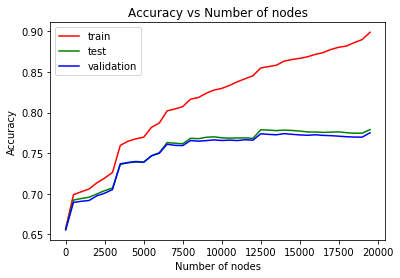

In [636]:
# Plotting the accuracies
plt.plot(count_arr, acc_train, label = "train", color='red')
plt.plot(count_arr, acc_test, label = "test", color='green')
plt.plot(count_arr, acc_val, label = "validation", color='blue')
plt.xlabel("Number of nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of nodes")
plt.legend()
plt.show()


### Part B

In [617]:
import copy

In [620]:
# Making a copy of the original tree
pruned_full_tree = copy.deepcopy(whole_tree)
remaining_size = total_count

In [621]:
# Get the size of the tree
def get_size(root: Node):
    
    if root is None:
        return 0
    elif root.type == NodeType.Leaf:
        return 1
    else:
        return 1 + get_size(root.right) + get_size(root.left)


In [626]:
# Global variables for post pruning stemp
maximum = get_accuracy(x_val, y_val, pruned_full_tree)
original = maximum
pruned_node = None
leaf_value = -1

# Post pruning starting tree with root
def post_pruning_step(root: Node, curr_node: Node, x, y, x_t, y_t, prediction):
    
    global maximum, x_val, y_val, original, pruned_node, leaf_value
    
    # Selecting the right partition
    x_new_r = np.array(x[x[:, curr_node.attribute_index] > curr_node.value, :])
    y_new_r = np.array(y[x[:, curr_node.attribute_index] > curr_node.value])
    
    # The split of train data
    x_new_t_r = np.array(x_t[x_t[:, curr_node.attribute_index] > curr_node.value, :])
    y_new_t_r = np.array(y_t[x_t[:, curr_node.attribute_index] > curr_node.value])
    
    pred_r = np.array(prediction[x[:, curr_node.attribute_index] > curr_node.value])
    
    # Selecting the left partition
    x_new_l = np.array(x[x[:, curr_node.attribute_index] <= curr_node.value, :])
    y_new_l = np.array(y[x[:, curr_node.attribute_index] <= curr_node.value])
    
    # The split of train data
    x_new_t_l = np.array(x_t[x_t[:, curr_node.attribute_index] <= curr_node.value, :])
    y_new_t_l = np.array(y_t[x_t[:, curr_node.attribute_index] <= curr_node.value])
    
    pred_l = np.array(prediction[x[:, curr_node.attribute_index] <= curr_node.value])
    
    # Removing left node 
    if curr_node.left is not None and curr_node.left.type != NodeType.Leaf and np.shape(y_new_l)[0] != 0:
        
        # Leaf prediction
        temp_data = np.bincount(y_new_t_l).argmax()
        
        # Check if accuracy increases
        pred_new = temp_data * np.ones_like(pred_l)
        count_change = np.sum(pred_new == y_new_l) - np.sum(pred_l == y_new_l)
        
        # The new accuracy
        accuracy = original + (count_change / np.shape(y_val)[0])
        
        # If accuracy increases
        if accuracy > maximum:
            maximum = accuracy
            pruned_node = curr_node.left
            leaf_value = temp_data
            
        
        # Continue pruning
        post_pruning_step(root, curr_node.left, x_new_l, y_new_l, x_new_t_l, y_new_t_l, pred_l)
        
    # Removing right node 
    if curr_node.right is not None and curr_node.right.type != NodeType.Leaf and np.shape(y_new_r)[0] != 0:
        
        # Leaf prediction
        temp_data = np.bincount(y_new_t_r).argmax()
         
        # Check if accuracy increases
        pred_new = temp_data * np.ones_like(pred_r)
        count_change = np.sum(pred_new == y_new_r) - np.sum(pred_r == y_new_r)
        
        # The new accuracy
        accuracy = original + (count_change / np.shape(y_val)[0])
        
        if accuracy > maximum:
            maximum = accuracy
            pruned_node = curr_node.right
            leaf_value = temp_data
        
        
        # Continue pruning
        post_pruning_step(root, curr_node.right, x_new_r, y_new_r, x_new_t_r, y_new_t_r, pred_r)
    
    return

In [627]:
# Assign values for global pruning values
def assign_global_pruning(x, y, root):
    
    global pruned_node, maximum, leaf_value, original
    
    # Assigning global variables for pruning
    maximum = get_accuracy(x, y, root)
    original = maximum
    pruned_node = None
    leaf_value = -1
    
    return

In [628]:
# Variables for plotting
acc_test = []
acc_train = []
acc_test = []
acc_val = []
count_arr = []
temp_count = 0

def post_pruning(root, x, y, x_test, y_test, x_train, y_train):
    
    global pruned_node, maximum, leaf_value, temp_count, original, remaining_size, acc_test, acc_train, acc_val, count_arr
    
    # Make a copy of the root    
    root_temp = copy.deepcopy(root)
        
    while True:
        
        # Assign global variables
        assign_global_pruning(x, y, root_temp)
        prediction = get_prediction(x, root_temp)
        
        # Data for plotting    
        acc_test.append(get_accuracy(x_test, y_test, root_temp))
        acc_train.append(get_accuracy(x_train, y_train, root_temp))
        acc_val.append(maximum)
        count_arr.append(remaining_size)
        print(temp_count, remaining_size, maximum)
        
        
        # Running for one step    
        post_pruning_step(root_temp, root_temp, x, y, x_train, y_train, prediction)
        if pruned_node is None:
            break
        
        temp_count += 1
        remaining_size -= (get_size(pruned_node) - 1)
        pruned_node.convert_to_leaf(leaf_value)
        

In [629]:
t0 = time()
post_pruning(pruned_full_tree, x_val, y_val, x_test, y_test, x_train, y_train)
print(time() - t0)

0 19977 0.7761913591692935
1 13385 0.7796680882625626
2 12179 0.7816614129427035
3 11539 0.7832838865195624
4 11089 0.7842110142777675
5 10625 0.7850454292601521
6 10079 0.7856944186908956
7 9983 0.7862970517337289
8 9929 0.7868069720007417
9 9773 0.7872705358798442
10 9151 0.7877340997589468
11 8881 0.788151307250139
12 8353 0.7885685147413314
13 8303 0.7889393658446134
14 8273 0.7893102169478954
15 8043 0.7896810680511774
16 7983 0.7900519191544595
17 7951 0.7903764138698313
18 7885 0.790700908585203
19 7647 0.7910254033005748
20 7487 0.7913498980159466
21 7393 0.7916280363434082
22 7335 0.7919061746708697
23 7289 0.792137956610421
24 7251 0.7923697385499722
25 7207 0.7926015204895235
26 7151 0.7928333024290747
27 7131 0.7930187279807157
28 7099 0.7932041535323567
29 7053 0.7933895790839978
30 6993 0.7935750046356388
31 6975 0.7937604301872798
32 6941 0.7939458557389208
33 6935 0.7941312812905619
34 6893 0.7943167068422029
35 6875 0.7945021323938438
36 6615 0.7946875579454848
37 6581

In [630]:
# Accuracy after pruning
print("Training accuracy after pruning:", acc_train[np.shape(acc_train)[0] - 1])
print("Validation accuracy after pruning:", acc_val[np.shape(acc_val)[0] - 1])
print("Test accuracy after pruning:", acc_test[np.shape(acc_test)[0] - 1])

Training accuracy after pruning: 0.8164510994699674
Validation accuracy after pruning: 0.8049786760615613
Test accuracy after pruning: 0.7939826619071902


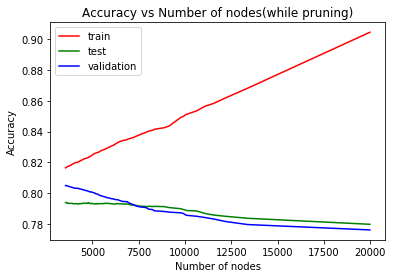

In [631]:
# Plotting the accuracies
plt.plot(count_arr, acc_train, label = "train", color='red')
plt.plot(count_arr, acc_test, label = "test", color='green')
plt.plot(count_arr, acc_val, label = "validation", color='blue')
plt.xlabel("Number of nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of nodes(while pruning)")
plt.legend()
plt.show()

### Part C

In [572]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [527]:
# The parameter grid
n_estimators = [50, 150, 250, 350, 450]
max_features = [0.1, 0.3, 0.5, 0.7, 0.9]
min_samples_split = [2, 4, 6, 8, 10]

In [535]:
# Assigning initial values
best_accuracy = 0
best_n_estimator = 50
best_max_feature = 0.1
best_min_split = 2
best_rfc = RandomForestClassifier(oob_score=True, n_estimators = 50, max_features=0.1, min_samples_split=2, n_jobs=4)

t0 = time()
for n in n_estimators:
    for m in max_features:
        for mi in min_samples_split:
            rfc = RandomForestClassifier(oob_score=True, n_estimators = n, max_features=m, min_samples_split=mi, n_jobs=4)

            print("Testing for" + str((n, m, mi)))

            rfc.fit(x_train, y_train)
            print("Accuracy", rfc.oob_score_)

            if rfc.oob_score_ > best_accuracy:
                best_accuracy = rfc.oob_score_
                best_n_estimator = n
                best_max_feature = m
                best_min_split = mi
                best_rfc = rfc
                
print("Time elapsed:", time() - t0)
print(best_accuracy, best_n_estimator, best_max_feature, best_min_split)

Testing for(50, 0.1, 2)
Accuracy 0.7985257985257985
Testing for(50, 0.1, 4)
Accuracy 0.802219028634123
Testing for(50, 0.1, 6)
Accuracy 0.8046605782454839
Testing for(50, 0.1, 8)
Accuracy 0.8061440514270702
Testing for(50, 0.1, 10)
Accuracy 0.8067930709440143
Testing for(50, 0.3, 2)
Accuracy 0.798185835921685
Testing for(50, 0.3, 4)
Accuracy 0.8019099717212925
Testing for(50, 0.3, 6)
Accuracy 0.8054023148362771
Testing for(50, 0.3, 8)
Accuracy 0.804397879869578
Testing for(50, 0.3, 10)
Accuracy 0.807225750621977
Testing for(50, 0.5, 2)
Accuracy 0.7984021757606663
Testing for(50, 0.5, 4)
Accuracy 0.8026053497751611
Testing for(50, 0.5, 6)
Accuracy 0.8037179546613509
Testing for(50, 0.5, 8)
Accuracy 0.8046451253998423
Testing for(50, 0.5, 10)
Accuracy 0.8053095977624279
Testing for(50, 0.7, 2)
Accuracy 0.7985721570627231
Testing for(50, 0.7, 4)
Accuracy 0.8008128196807442
Testing for(50, 0.7, 6)
Accuracy 0.8035016148223696
Testing for(50, 0.7, 8)
Accuracy 0.8047378424736915
Testing for(5

In [575]:
# Predicting on test and validation
pred_train = best_rfc.predict(x_train)
pred_test = best_rfc.predict(x_test)
pred_val = best_rfc.predict(x_val)

In [577]:
# Accuracies
print("Train accuracy: ", accuracy_score(y_train, pred_train))
print("Test accuracy: ", accuracy_score(y_test, pred_test))
print("Validation accuracy: ", accuracy_score(y_val, pred_val))
print("Out of bag score: ", best_rfc.oob_score_)

Train accuracy:  0.8731784958200053
Test accuracy:  0.8089564693338278
Validation accuracy:  0.8065084368625997
Out of bag score:  0.8109035278846599


### Part D

In [580]:
# Varying n_estimators
n_estimator_array = np.linspace(best_n_estimator - 50, best_n_estimator + 50, 10, dtype=int)

In [581]:
test_acc = []
val_acc = []

# Varying n_estimators
for n in n_estimator_array:
    rfc = RandomForestClassifier(oob_score=True, 
                                 n_estimators = n, 
                                 max_features=best_max_feature, 
                                 min_samples_split=best_min_split, 
                                 n_jobs=4)
    print("Testing for", n)
    # Fitting the model
    rfc.fit(x_train, y_train)
    print("Score:", rfc.oob_score_)
    
    # Prediction
    pred_test = rfc.predict(x_test)
    pred_val = rfc.predict(x_val)
    
    # Saving the data
    test_acc.append(accuracy_score(y_test, pred_test))
    val_acc.append(accuracy_score(y_val, pred_val))
    

Testing for 400
Score: 0.8102699612133575
Testing for 411
Score: 0.8110116978041506
Testing for 422
Score: 0.8109962449585091
Testing for 433
Score: 0.809667300233338
Testing for 444
Score: 0.80999180999181
Testing for 455
Score: 0.8097291116159041
Testing for 466
Score: 0.810609923817471
Testing for 477
Score: 0.8090337335620355
Testing for 488
Score: 0.8107335465826032
Testing for 500
Score: 0.810965339267226


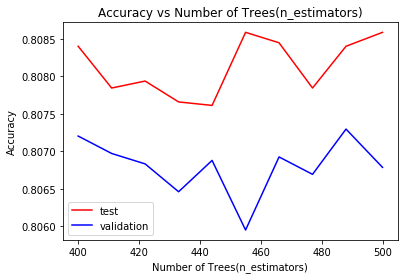

In [583]:
# Plotting the accuracies
plt.plot(n_estimator_array, test_acc, color='red', label = "test")
plt.plot(n_estimator_array, val_acc, color='blue', label = "validation")
plt.xlabel("Number of Trees(n_estimators)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of Trees(n_estimators)")
plt.legend()
plt.show()

In [590]:
# Varying max_features
max_feature_array = np.linspace(best_max_feature - 0.05, best_max_feature + 0.1, 10)

In [591]:
test_acc_max = []
val_acc_max = []

# Varying max_features
for m in max_feature_array:
    rfc = RandomForestClassifier(oob_score=True, 
                                 n_estimators = best_n_estimator, 
                                 max_features=m, 
                                 min_samples_split=best_min_split, 
                                 n_jobs=4)
    print("Testing for", m)
    # Fitting the model
    rfc.fit(x_train, y_train)
    print("Score:", rfc.oob_score_)
    
    # Prediction
    pred_test = rfc.predict(x_test)
    pred_val = rfc.predict(x_val)
    
    # Saving the data
    test_acc_max.append(accuracy_score(y_test, pred_test))
    val_acc_max.append(accuracy_score(y_val, pred_val))

Testing for 0.05
Score: 0.810285414058999
Testing for 0.06666666666666668
Score: 0.8104090368241311
Testing for 0.08333333333333334
Score: 0.8088792051056202
Testing for 0.1
Score: 0.8099145457636023
Testing for 0.11666666666666668
Score: 0.810965339267226
Testing for 0.13333333333333336
Score: 0.8101308856025837
Testing for 0.15000000000000002
Score: 0.8109498864215845
Testing for 0.16666666666666669
Score: 0.8105481124349049
Testing for 0.18333333333333335
Score: 0.8101617912938668
Testing for 0.2
Score: 0.8101617912938668


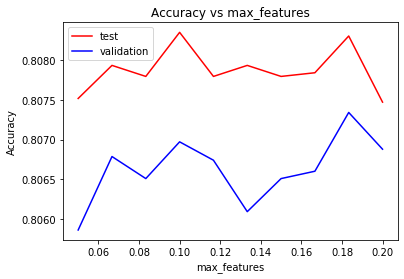

In [593]:
# Plotting the accuracies
plt.plot(max_feature_array, test_acc_max, color='red', label = "test")
plt.plot(max_feature_array, val_acc_max, color='blue', label = "validation")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.title("Accuracy vs max_features")
plt.legend()
plt.show()

In [598]:
# Varying min_samples_split
min_samples_array = np.linspace(best_min_split - 5, best_min_split + 5, 10, dtype=int)
min_samples_array

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 15])

In [600]:
test_acc_min = []
val_acc_min = []

# Varying max_features
for m in min_samples_array:
    rfc = RandomForestClassifier(oob_score=True, 
                                 n_estimators = best_n_estimator, 
                                 max_features=best_max_feature, 
                                 min_samples_split=m, 
                                 n_jobs=4)
    print("Testing for", m)
    # Fitting the model
    rfc.fit(x_train, y_train)
    print("Score:", rfc.oob_score_)
    
    # Prediction
    pred_test = rfc.predict(x_test)
    pred_val = rfc.predict(x_val)
    
    # Saving the data
    test_acc_min.append(accuracy_score(y_test, pred_test))
    val_acc_min.append(accuracy_score(y_val, pred_val))

Testing for 5
Score: 0.8074575433065999
Testing for 6
Score: 0.8081529213604686
Testing for 7
Score: 0.8095282246225642
Testing for 8
Score: 0.80908009209896
Testing for 9
Score: 0.8098836400723193
Testing for 10
Score: 0.810609923817471
Testing for 11
Score: 0.8105017538979803
Testing for 12
Score: 0.8110271506497921
Testing for 13
Score: 0.8119079628513591
Testing for 15
Score: 0.8120933969990574


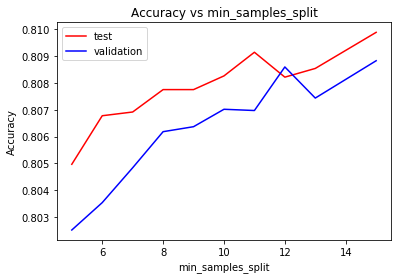

In [601]:
# Plotting the accuracies
plt.plot(min_samples_array, test_acc_min, color='red', label = "test")
plt.plot(min_samples_array, val_acc_min, color='blue', label = "validation")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Accuracy vs min_samples_split")
plt.legend()
plt.show()